In [2]:
from utils.functions import get_path, search_files, get_filename
from utils.config import (
    CBIS_DDSM_CONVERTED_DATA_PATH, CBIS_DDSM_PREPROCESSED_DATA_PATH, CBIS_DDSM_DB_PATH, MIAS_CONVERTED_DATA_PATH,
    MIAS_PREPROCESSED_DATA_PATH, INBREAST_CONVERTED_DATA_PATH, INBREAST_PREPROCESSED_DATA_PATH,
    INBREAST_DB_XML_ROI_PATH
)

from typing import io

import cv2
import plistlib
import os
import pydicom

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

root_path = r'C:\Users\USUARIO\Desktop\Master Data Science\TFM\Code\src'
% matplotlib inline

UsageError: Line magic function `%` not found.


In [22]:
# Se obtiene el número de imagenes del dataset inbreast
l = []
for file in search_files(get_path(root_path, CBIS_DDSM_CONVERTED_DATA_PATH, 'FULL', create=False), ext='png', in_subdirs=False):
    l.append([get_filename(file)])

cbis_df = pd.DataFrame(l, columns=['FILE_NAME'])

In [24]:
# Se obtienen las mascaras convertidas
l = []
for file in search_files(get_path(root_path, CBIS_DDSM_CONVERTED_DATA_PATH, 'MASK', create=False), ext='png', in_subdirs=False):
    l.append([get_filename(file)])

cbis_mask_df = pd.DataFrame(l, columns=['MASK_FILE_NAME'])

In [25]:
# Imagenes que no tienen mascara convertida
cbis_df[~cbis_df.FILE_NAME.isin(cbis_mask_df.MASK_FILE_NAME)]

,FILE_NAME


In [28]:
# Se obtienen las mascaras procesadas
l = []
for file in search_files(get_path(root_path, CBIS_DDSM_PREPROCESSED_DATA_PATH, 'MASK', create=False), ext='png', in_subdirs=False):
    l.append([get_filename(file)])

cbis_mask_df_proc = pd.DataFrame(l, columns=['MASK_FILE_NAME'])

In [29]:
# Imagenes que no tienen mascara convertida
cbis_df[~cbis_df.FILE_NAME.isin(cbis_mask_df_proc.MASK_FILE_NAME)]

,FILE_NAME
189,Mass-Test_P_01090_RIGHT_MLO
387,Mass-Training_P_00092_RIGHT_CC
685,Mass-Training_P_00596_RIGHT_CC
759,Mass-Training_P_00720_RIGHT_MLO
765,Mass-Training_P_00730_RIGHT_CC


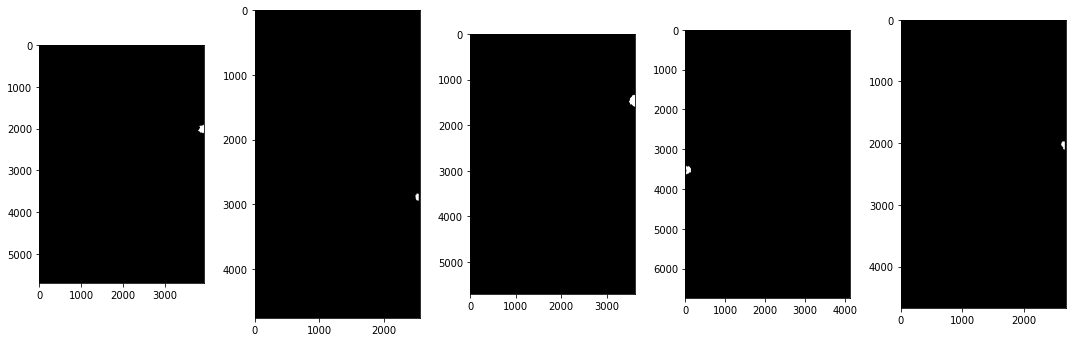

In [32]:
fig, ax = plt.subplots(1, 5, figsize=(15, 7))

for file, axes in zip(cbis_df[~cbis_df.FILE_NAME.isin(cbis_mask_df_proc.MASK_FILE_NAME)].FILE_NAME.values.tolist(), ax.flatten()):

    axes.imshow(cv2.imread(get_path(root_path, CBIS_DDSM_CONVERTED_DATA_PATH, 'MASK', f'{file}.png')))

fig.tight_layout()

**Conclusión:** EL CROP DE LAS IMAGENES PRODUCE QUE SE PIERDA LA MASCARA Y SE EXCLUYAN DICHAS IMAGENES

In [5]:
# Se obtiene el número de carpetas con _N de cada imagen
cbis_mask_ori = pd.DataFrame(
    data=search_files(file=f'{root_path}\\{CBIS_DDSM_DB_PATH}\\Mass-*_[0-9]', ext='dcm', in_subdirs=True),
    columns=['MASK_FILEPATH']
)
cbis_mask_ori.loc[:, 'FILE_NAME'] = cbis_mask_ori.MASK_FILEPATH.apply(lambda x: "_".join(x.split(os.sep)[-4].split("_")[:-1]))

In [11]:
cbis_mask_ori.loc[:, 'IS_MASK'] = cbis_mask_ori.MASK_FILEPATH.apply(
    lambda x: 1 if len(np.unique(pydicom.dcmread(x).pixel_array)) == 2 else 0)



In [59]:
cbis_roi = pd.DataFrame(
    data=search_files(file=f'{root_path}\\{CBIS_DDSM_PREPROCESSED_DATA_PATH}\\CROP\\CONF0', ext='png', in_subdirs=False),
    columns=['ROI_FILEPATH']
)
cbis_roi.loc[:, 'FILE_NAME'] = cbis_roi.ROI_FILEPATH.apply(lambda x: "_".join(get_filename(x).split('_')[1:-1]))
cbis_roi.loc[:, 'IMG_SIZE'] = cbis_roi.ROI_FILEPATH.apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY).shape)

In [60]:
# Se analizan los que estan en ROI_FILEPATH ya que se suprimen las muestras que son benign without callback
cbis_roi_analize = cbis_mask_ori[cbis_mask_ori.FILE_NAME.isin(cbis_roi.FILE_NAME)].groupby('FILE_NAME', as_index=False).IS_MASK.sum()
len(cbis_roi) - cbis_roi_analize.IS_MASK.sum()

-2

existen 48 recortes generados por ruido en las mascaras. Se analizan cuales son.

In [61]:
check_rois = pd.merge(
    left=cbis_roi.FILE_NAME.value_counts().reset_index().rename(columns={'index': 'FILE_NAME', 'FILE_NAME': 'N_CROPS'}),
    right=cbis_roi_analize.rename(columns={'IS_MASK': 'N_MASK'}),
    on='FILE_NAME',
    how='left'
)


In [62]:
check_rois.loc[:, 'DIFF']=check_rois.N_CROPS - check_rois.N_MASK
check_rois[check_rois.DIFF != 0].DIFF.sum()

# Las imagenes que contienen cortes adicionales son:
errors = pd.merge(left=cbis_roi, right=check_rois[check_rois.DIFF != 0], on='FILE_NAME')
errors.loc[:, 'AREA'] = errors.IMG_SIZE.str[1].astype(int) * errors.IMG_SIZE.str[0].astype(int)
errors.loc[:, 'LIMIT'] = errors.sort_values('AREA', ascending=False).groupby('FILE_NAME').cumcount() + 1

errors[errors.LIMIT != errors.N_MASK]

,ROI_FILEPATH,FILE_NAME,IMG_SIZE,N_CROPS,N_MASK,DIFF,AREA,LIMIT
0,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_00778_RIGHT_MLO,"(402, 314)",1,2,-1,126228,1
1,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_00802_LEFT_MLO,"(1082, 2130)",1,3,-2,2304660,1
2,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_01262_RIGHT_CC,"(164, 80)",3,2,1,13120,3
3,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_01262_RIGHT_CC,"(674, 346)",3,2,1,233204,1


El total de máscaras son 1560.

El resultado de los rois son 1553 debido a:
Casos:
- 5 rois borrados antriormente por el crop derecho de la mascara. (-5)
- 01262_RIGHT_CC: Se generan 3 rois debido al crop derecho de la mascara. Separa una única región en 2. (+1)
- 00802_LEFT_MLO: Las 3 máscaras se solapan, resultando un único ROI. (-2)
- 00778_RIGHT_MLO: Las 2 máscaras se solapan, resultando un único ROI. (-1)

El total de máscaras es de 1473 despues de realizar el agregado.
El resultado de las imagenes y de las máscaras es de 1468 debido a que:
Casos:
- 5 rois borrados antriormente por el crop derecho de la mascara. (-5)




